# Preliminary GRIP Results 

This document presents some inital data analysis from the first patient and the first control of the GRIP study. It includes 

1) Superficial description of the equations/formulae used to go from MR-images to concentrations. 
2) Initial data analysis and comparison between the two subjects.
3) Simulation of concentration spread using simulation, with comparison.

## Concentrations

The concentration within a given pixel at time $t$ is estimated according to the equation:

$$
    c(t) = \frac{1.0}{r} \left(\frac{1}{T_1(t)} - \frac{1}{T_1(0)}\right)
$$

where $r$ denotes a so-called relaxivity-constant, and $T_1$ is the "$T_1$-relaxation time" of the given voxel. $T_1(0)$ refers to the $T_1$-values measured before tracer-injection. The $T_1$-values may be acquired from the LookLocker-sequences. 

However, since the direct acquisition of $T_1$-values from LookLocker have not yet been implemented, we have to estimate them from the signal intensities $S(t)$ of the so-called $T1$-weighted images (such as the one shown above). The estimated value is given according to

$$
    T_1(t) = T_1^{ref} - \frac{1}{b}\log\left(\frac{S(t)}{S(0)}\right)
$$

where $T_1^{ref}$ refers to previously measured $T_1$-value within various types of brain tissue found in literature, and $b$ refers to ... (not sure yet, will have to check).


*NB: The expressions "$T_1$-time" and "$T_1$-values" refer to the "$T_1$ relaxation time", whereas "$T_1$-weighted images" refer to the grayscale images that is shown in this document. *

In [1]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
from pathlib import Path
import nibabel

figpath = Path("report-images")

cm = "turbo"
t1_weighted = nibabel.load("DATA/PAT_002/mri/T1.mgz")
im = t1_weighted.get_fdata()
concentration = nibabel.load("DATA/PAT_002/CONCS_synthetic/20230214_094033.mgz")
im_conc = concentration.get_fdata()
slice_ = np.s_[:, 100, :]
plt.figure()
plt.imshow(im[slice_].T, origin="lower", cmap="gray")
plt.xticks([])
plt.yticks([])
plt.savefig(figpath / "example-t1weight.png", bbox_inches="tight")
plt.clf()

slice_ = np.s_[90:110, 100, 90:110]
plt.figure()
plt.imshow(im[slice_].T, origin="lower", cmap="gray")
plt.xticks([])
plt.yticks([])
plt.savefig(figpath / "example-t1weight-zoom.png", bbox_inches="tight")
plt.clf()

slice_ = np.s_[:, 100, :]
plt.figure()
plt.imshow(im[slice_].T, origin="lower", cmap="gray")
c=plt.imshow(im_conc[slice_].T, origin="lower", vmin=0, vmax=0.4, cmap=cm)
plt.xticks([])
plt.yticks([])
plt.colorbar(c, label="Concentration (mM)")
plt.savefig(figpath / "example-concentration.png", bbox_inches="tight")
plt.clf()
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Below is a few-images showing an example of a so-called $T_1$-weighted image, the reconstructed concentration and a zoomed-in picture of the $T_1$-weighted image, which I included in case you would like to highlight that the computation is done per voxel. All of them are available in the accompanying figure-folder so you can resize them as you need.

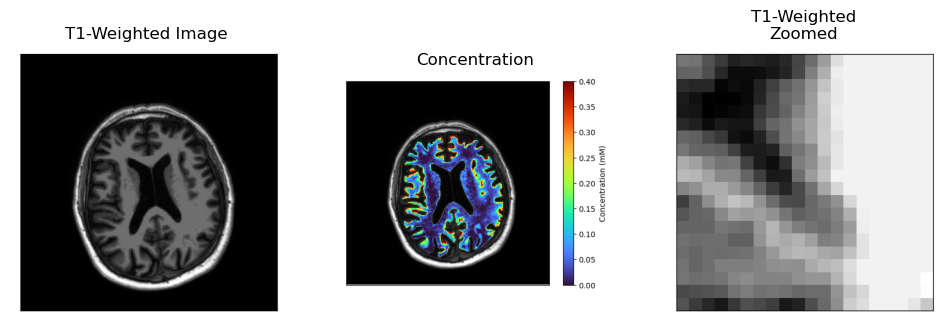

In [2]:
im0 = PIL.Image.open(figpath / "example-t1weight.png")
im1 = PIL.Image.open(figpath / "example-t1weight-zoom.png")
im2 = PIL.Image.open(figpath / "example-concentration.png")

fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(im0)
axs[0].set_title("T1-Weighted Image")
axs[2].imshow(im1)
axs[2].set_title("T1-Weighted\nZoomed")
axs[1].imshow(im2)
axs[1].set_title("Concentration")
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
plt.show()

## Simulation
To investigate to which degree the solute transport may be described by diffusion, we perform computer simulations, aka. in-silico studies of the diffusion process. To do this, we start by expressing the diffusion process in terms of a partial differential equation (PDE);

$$
\left\{
\begin{aligned}
    \frac{\partial c}{\partial t} - \nabla \cdot (D \nabla c) &= 0 \\
                                     c\vert_{\partial \Omega} &= \tilde c\\
\end{aligned}
\right.
$$

The first line is just Fick's seconds law of diffusion, and roughly states that solutes moves from regions of high concentration to low concentration. (Or to be slightly  more precise, it wants to reduce curvature and seek towards linear concentration-profiles). The $D$ is the *effective* diffusion coefficient and is estimated from literature values for the given tracer molecule. This estimate will be improved in the future by including data from DTI.

The second line is the boundary condition, which is an additional requirement for the equation to have a solution. The one stated above means that **on the boundary** of the brain, typically denoted $\partial \Omega$ the concentration should be equal to some function $\tilde c$. This function is set to be the linear interpolation in time between the data taken from the MR-images at different times. 

To run a simulation of the system, entails repeatedly solving the above equation by a numerical approximation technique called the finite element method (FEM). The method works on a "mesh" which is typically a 3D reconstruction of the brain put together by many small *tetrahedra*, or small pyramids. To create this from the brain we use a program called FreeSurfer combined with other software, and the result is shown below. The concentrations here are 30h after injection. In the folder I also included an image with a blue and red colormap in case that is preferred, so just say if I should redo the figure with this colormap.

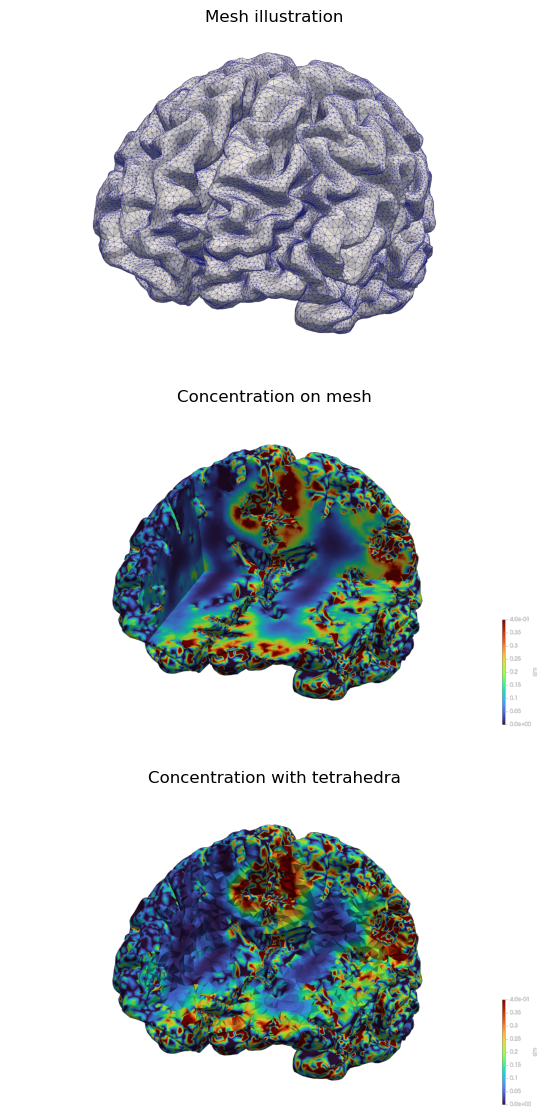

In [3]:
im0 = PIL.Image.open(figpath / "mesh-whole.png")
im1 = PIL.Image.open(figpath / "concentration-turbo.png")
im2 = PIL.Image.open(figpath / "concentration-crinkle.png")

fig, axs = plt.subplots(3, 1, figsize=(16, 20))
axs[0].imshow(im0)
axs[0].set_title("Mesh illustration")
axs[1].imshow(im1)
axs[1].set_title("Concentration on mesh")
axs[2].imshow(im2)
axs[2].set_title("Concentration with tetrahedra")
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
plt.show()

After simulation, these data are mapped back into a voxelized MR-image, which makes it easier to compare the simulation results with the MR-data:

### Transversal Image 

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

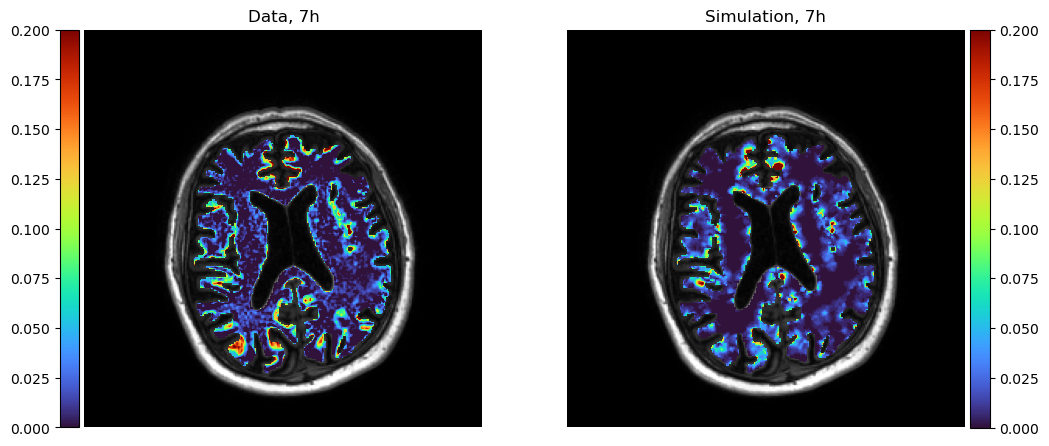

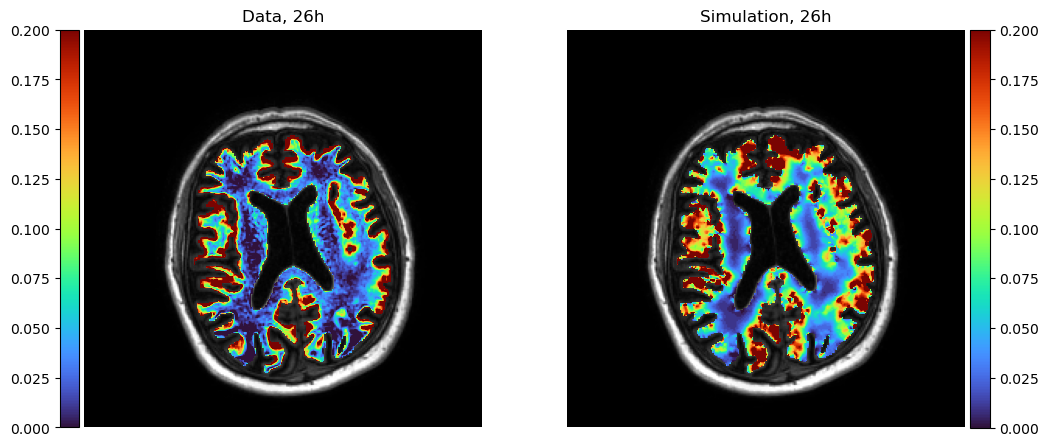

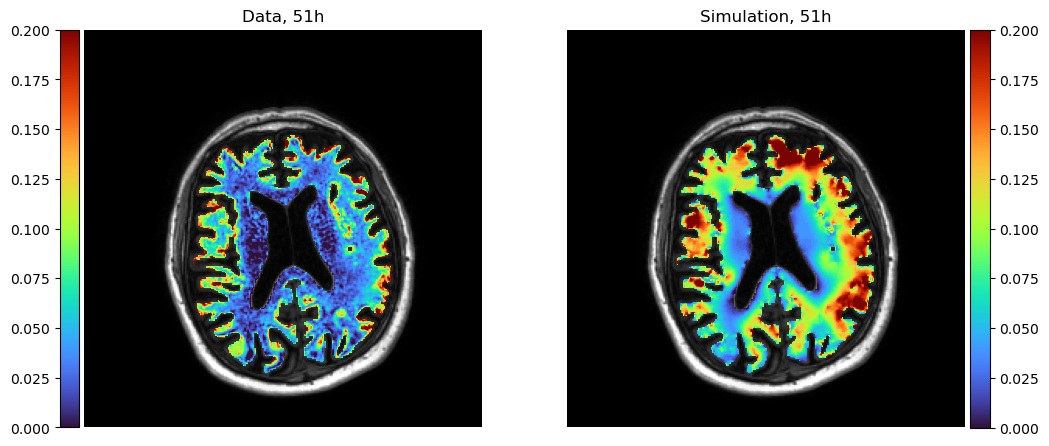

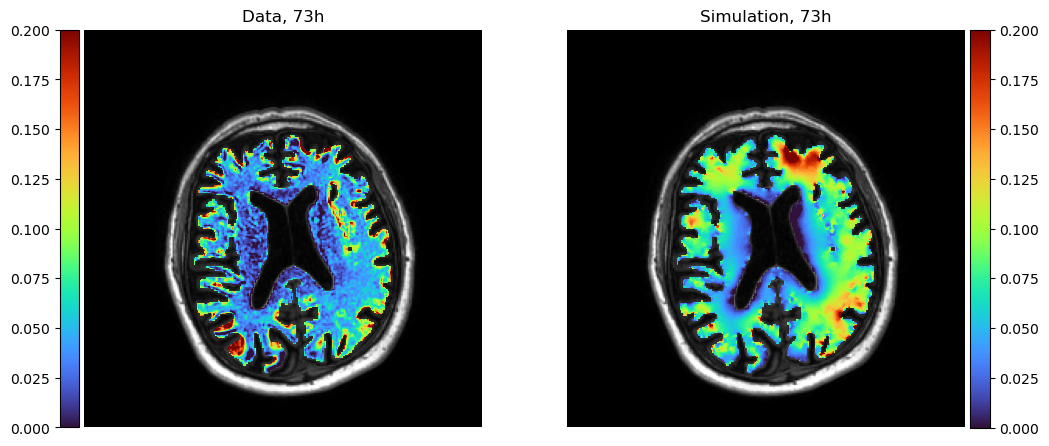

In [5]:
slice_ = np.s_[:, 100, :]
t1_weighted = nibabel.load("DATA/PAT_002/mri/T1.mgz")
t1 = t1_weighted.get_fdata()[slice_]
mask = nibabel.load("DATA/PAT_002/mri/parenchyma_only.mgz").get_fdata()
mask[mask <= 0.] = np.nan

conc_path = Path("DATA/PAT_002/CONCS_synthetic")
sim_path = Path("DATA/PAT_002/SIMULATION")
concs = sorted(conc_path.glob("*.mgz"))[1:]
sims = sorted(sim_path.glob("diffusion*"))[1:]
for conc, sim in zip(concs, sims):
    h = int(sim.stem.split("_")[1][:2])
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    
    for ax in axs:
        ax.imshow(t1.T, origin="lower", cmap="gray")
    
    im_conc = nibabel.load(conc).get_fdata()
    im_sim = nibabel.load(sim).get_fdata() * mask
    c = axs[0].imshow(im_conc[slice_].T, origin="lower", vmin=0, vmax=0.2, cmap=cm)
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('left', size='5%', pad=0.05)
    fig.colorbar(c, cax=cax, orientation='vertical', ticklocation='left')
    axs[0].set_title(f"Data, {h}h")

    axs[1].imshow(im_sim[slice_].T, origin="lower", vmin=0, vmax=0.2, cmap=cm)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(c, cax=cax, orientation='vertical')
    axs[1].set_title(f"Simulation, {h}h")

    
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        
    fig.savefig(figpath / f"PAT_002-data-simulation-comparison_transversal_{h}h.png", bbox_inches="tight")
    plt.show()

### Coronal 

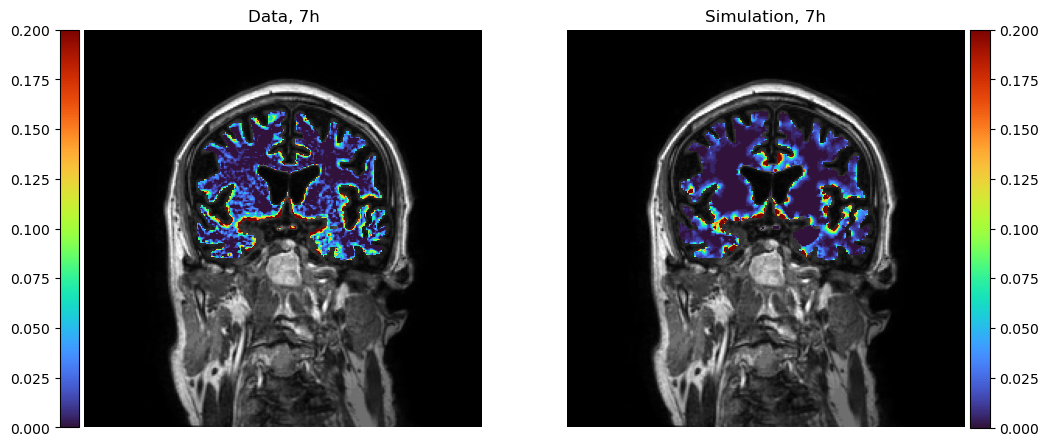

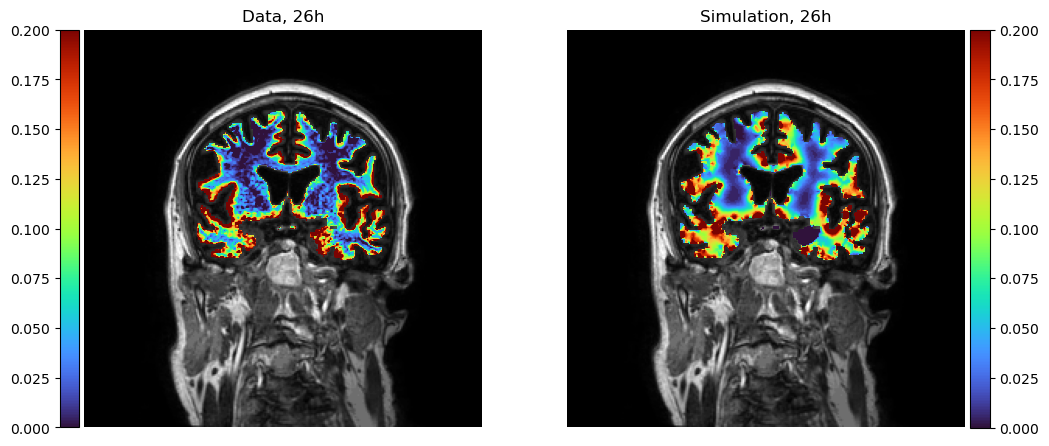

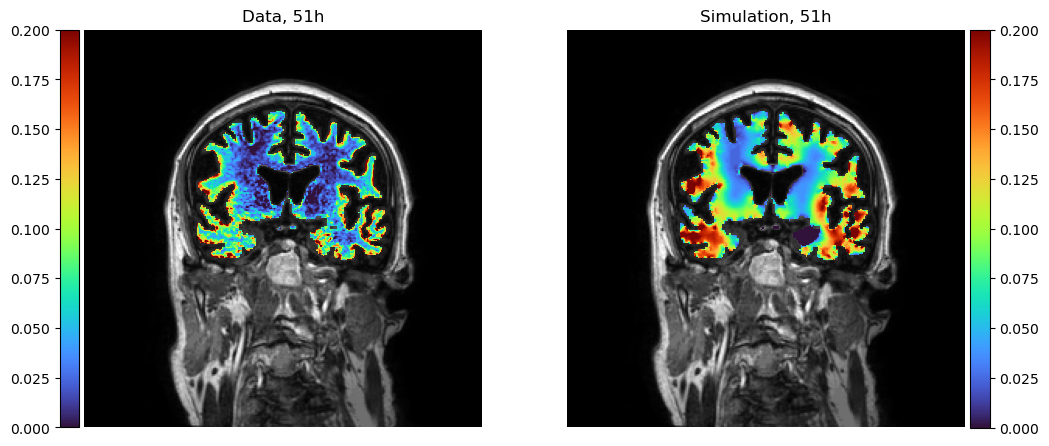

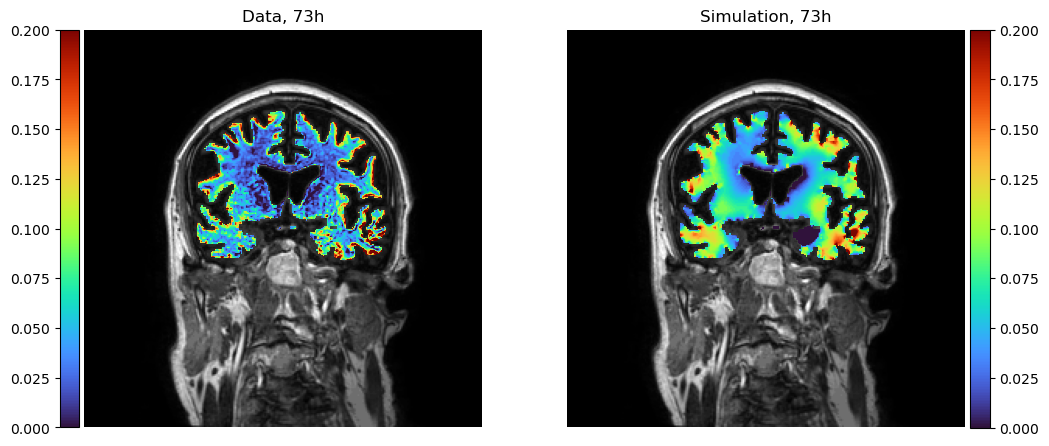

In [6]:
slice_ = np.s_[:, ::-1, 130]
t1_weighted = nibabel.load("DATA/PAT_002/mri/T1.mgz")
t1 = t1_weighted.get_fdata()[slice_]
mask = nibabel.load("DATA/PAT_002/mri/parenchyma_only.mgz").get_fdata()
mask[mask <= 0.] = np.nan

conc_path = Path("DATA/PAT_002/CONCS_synthetic")
sim_path = Path("DATA/PAT_002/SIMULATION")
concs = sorted(conc_path.glob("*.mgz"))[1:]
sims = sorted(sim_path.glob("diffusion*"))[1:]
for conc, sim in zip(concs, sims):
    h = int(sim.stem.split("_")[1][:2])
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    
    for ax in axs:
        ax.imshow(t1.T, cmap="gray")
    
    im_conc = nibabel.load(conc).get_fdata()
    im_sim = nibabel.load(sim).get_fdata() * mask
    c = axs[0].imshow(im_conc[slice_].T, origin="lower", vmin=0, vmax=0.2, cmap=cm)
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('left', size='5%', pad=0.05)
    fig.colorbar(c, cax=cax, orientation='vertical', ticklocation='left')
    axs[0].set_title(f"Data, {h}h")

    axs[1].imshow(im_sim[slice_].T, origin="lower", vmin=0, vmax=0.2, cmap=cm)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(c, cax=cax, orientation='vertical')
    axs[1].set_title(f"Simulation, {h}h")

    
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        
    fig.savefig(figpath / f"PAT_002-data-simulation-comparison_coronal_{h}h.png", bbox_inches="tight")
    plt.show()

## Initial Data Analysis

One of the questions we hope to answer throughout the study is whether there is a difference in influx- and/or efflux of the tracer molecules in the brain of Parkinson patients as compared to the controls. As a simple visualization of this, we've created the box-plots which compares the concentrations in the two patients, for various parts of the brain.

To create this plots we do the following:
1) From FreeSurfer, the program we used for 3D reconstruction of the brain, we also get a segmentation of the brain (see image below)
2) For a region of interest, for example the white-matter, gray-matter, basal-ganglias or the whole-brain, we extract the concentrations in the voxels of the corresponding region of interest.
3) Each of the voxels are considered "one data point". From this we create a box-plot which marks the following: 
    1. The box extends from the 1st to the 3rd quartile (see https://www150.statcan.gc.ca/n1/edu/power-pouvoir/ch12/5214890-eng.htm if unfamiliar with expresions)
    2. The line on the middle of the boxes marks the median value.
    3. The whiskers extends either to the most far-out data-point (i.e. voxel concentration value), or stops at a point for which points beyond are considered "outliers". An outlier is in this context is defined as any point for which the distance to the box is more than 2 times the length of box. It should be noted that in this case, this might seem a bit "off" since there are so many points above the whiskers. However, this partly comes from the fact that there are som many points within each group.
4) Such a box is created for each subject at each time-point.

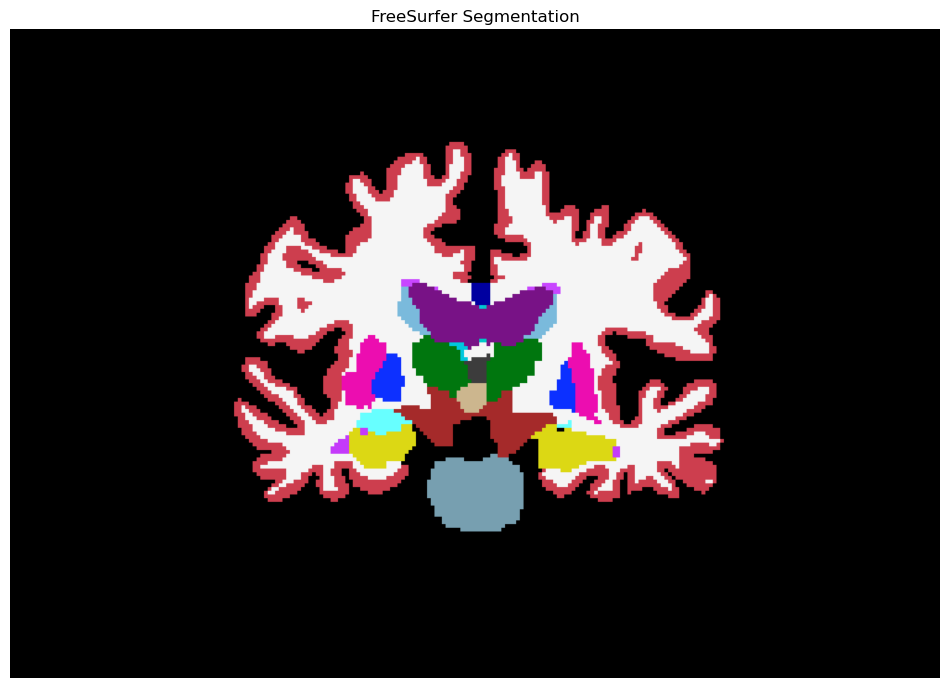

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 14))
ax.imshow(PIL.Image.open("report-images/freesurfer-segmentation.png"))
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.set_title("FreeSurfer Segmentation")
plt.show()

In [5]:
from create_dataframe import read_concentrations_file
from seg_groups import default_segmentation_groups
import pprint
import pandas as pd
import matplotlib.patheffects as pe

def xth_percentile(x):
    def perc(y):
        return y.quantile(x)
    return perc

def p10(x):
    return x.quantile(0.1)

def p90(x):
    return x.quantile(0.9)

def flatten_dataframe(dataframe: pd.DataFrame) -> pd.Series:
    mi = pd.MultiIndex.from_product([dataframe.columns, dataframe.index])
    return pd.Series(dataframe.to_numpy().flatten(order="F"), index=mi)


def create_group_statistics(patientid, seg_groups=None):
    if seg_groups is None:
        seg_groups = default_segmentation_groups()
    aggregations = ["median", "mean", "std", p10, p90]
    drop_cols = ["i", "j", "k"]
    df = read_concentrations_file(
        f"DATA/{patientid}/STATISTICS/concentrations.csv"
    ).dropna().drop(drop_cols, axis=1)

    stat = df.dropna().groupby(["aseg"]).agg(aggregations)
    for group, aseg_idx in seg_groups.items():
        mask = df["aseg"].isin(seg_groups[group])
        df_group  = df[mask].drop("aseg", axis=1)
        if df_group.size> 0:
            gr_stats = df_group.agg(aggregations)
            stat.loc[group] = flatten_dataframe(gr_stats)
    stat.to_csv(f"DATA/{patientid}/STATISTICS/group_statistics.csv", index=False)
    return stat


def patient_aseg_group_data(patient, patdir, group):
    drop_cols = ["i", "j", "k"]
    df = read_concentrations_file(
        patdir / "STATISTICS/concentrations.csv"
    ).dropna().drop(drop_cols, axis=1)
    mask = df["aseg"].isin(seg_groups[group])
    out = df[mask].drop(["aseg"], axis=1).assign(patientid=patient)
    out.columns=[0, 7, 26, 50, 72, "patientid"]
    return out


def melt_patient_group_data(patients, group, seg_groups=None):
    if seg_groups is None:
        seg_groups = default_segmentation_groups()
    df = pd.concat(
        [patient_aseg_group_data(pat, patdir, group) for pat, patdir in patients.items()],
        ignore_index=True,
    )
    return pd.melt(df, id_vars=['patientid'], var_name="hours", value_name="median_concentration")

def median_value_patient_group_data(patient, group):
    return patient_aseg_group_data(
        patient,
        Path(f"DATA/{patient}"),
        group
    ).drop(["patientid"], axis=1).median()

def get_all_labels(patientid="PAT_002"):
    drop_cols = ["i", "j", "k"]
    df = read_concentrations_file(
        f"DATA/{patientid}/STATISTICS/concentrations.csv"
    ).dropna().drop(drop_cols, axis=1)
    return sorted(df["aseg"].unique())

from create_dataframe import read_concentrations_file
from seg_groups import default_segmentation_groups
import pprint
import pandas as pd
import seaborn

seg_groups = default_segmentation_groups()
seg_groups.pop("csf")
pprint.pprint(seg_groups)
seg_groups["whole-brain"] = get_all_labels()

{'accumbens': [26, 58],
 'amygdala': [18, 54],
 'basal-ganglias': [11, 50, 12, 51, 13, 52, 17, 53, 18, 54, 26, 58],
 'caudate': [11, 50],
 'cerebellum': [7, 8, 46, 47],
 'corpus-callosum': [251, 252, 253, 254, 255],
 'cortex-cerebellar': [8, 47],
 'cortex-cerebral': [3, 42],
 'gray-matter': [3, 42, 8, 47, 11, 50, 12, 51, 13, 52, 17, 53, 18, 54, 26, 58],
 'hippocampus': [17, 53],
 'pallidum': [13, 52],
 'putamen': [12, 51],
 'white-matter': [2, 41, 7, 46, 77, 78, 70, 77, 78, 79, 80, 100, 109],
 'wm-cerebellar': [7, 46],
 'wm-cerebral': [2, 41],
 'wm-hypointensities': [77, 78, 70],
 'wm-pathological': [77, 78, 79, 80, 100, 109]}


In [6]:
patients = {
    "PAT_001": Path("DATA/PAT_001"),
    "PAT_002": Path("DATA/PAT_002")
}

for patient in patients:
    create_group_statistics(patient, seg_groups)

KeyboardInterrupt: 

### Box Plots

In [ ]:
import matplotlib.patheffects as pe
path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()]
groups=["white-matter", "gray-matter", "basal-ganglias", "whole-brain"]
for groupname in groups:
    print("Plotting ", groupname)
    melted = melt_patient_group_data(patients, groupname, seg_groups)

    fig, ax = plt.subplots()

    g = seaborn.boxplot(
        melted,
        x='hours',
        y='median_concentration',
        hue='patientid',
        flierprops={
            "marker": "x",
            "color": "r"
        },
        fliersize=2.0,
        whis=2
    )
    title = groupname.replace("-", " ").title()
    ax.legend(title="")
    ax.set_title(title)
    ax.set_ylim(
        melted["median_concentration"].quantile(0.01),
        melted["median_concentration"].quantile(0.99)
    )
    ax.set_ylabel("Concentration (mM)")
    ax.set_xlabel("Hours from injection")

    fig.savefig(figpath / f"boxplot_{groupname}.png", bbox_inches="tight")
    plt.clf()
    fig, ax = plt.subplots()

    g = seaborn.boxplot(
        melted,
        x='hours',
        y='median_concentration',
        hue='patientid',
        flierprops={
            "marker": "x",
            "color": "r"
        },
        fliersize=2.0,
        whis=2
    )
    title = groupname.replace("-", " ").title()
    for pat in patients:
        median_curve = median_value_patient_group_data(pat, groupname)
        ax.plot(median_curve.values, ls="--", lw=2, path_effects=path_effects)
    ax.legend(title="")
    ax.set_title(title)
    ax.set_ylim(
        melted["median_concentration"].quantile(0.05),
        melted["median_concentration"].quantile(0.95)
    )
    ax.set_ylabel("Concentration (mM)")
    ax.set_xlabel("Hours from injection")

    fig.savefig(figpath / f"boxplot_{groupname}_w_curves.png", bbox_inches="tight")
    plt.clf()

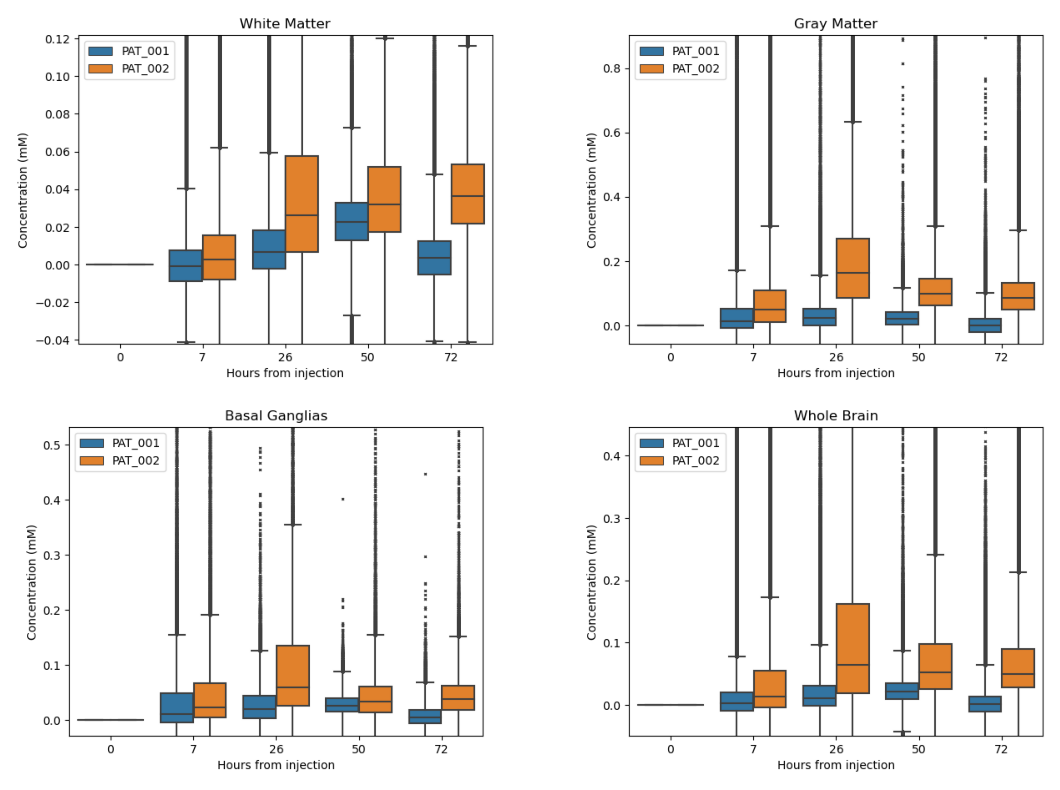

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for idx, group in enumerate(groups):
    im = PIL.Image.open(figpath / f"boxplot_{group}.png")
    ax_idx = np.unravel_index(idx, (2, 2))
    axs[ax_idx].imshow(im)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
plt.tight_layout()
plt.show()

### Box Plots with Median Curves 

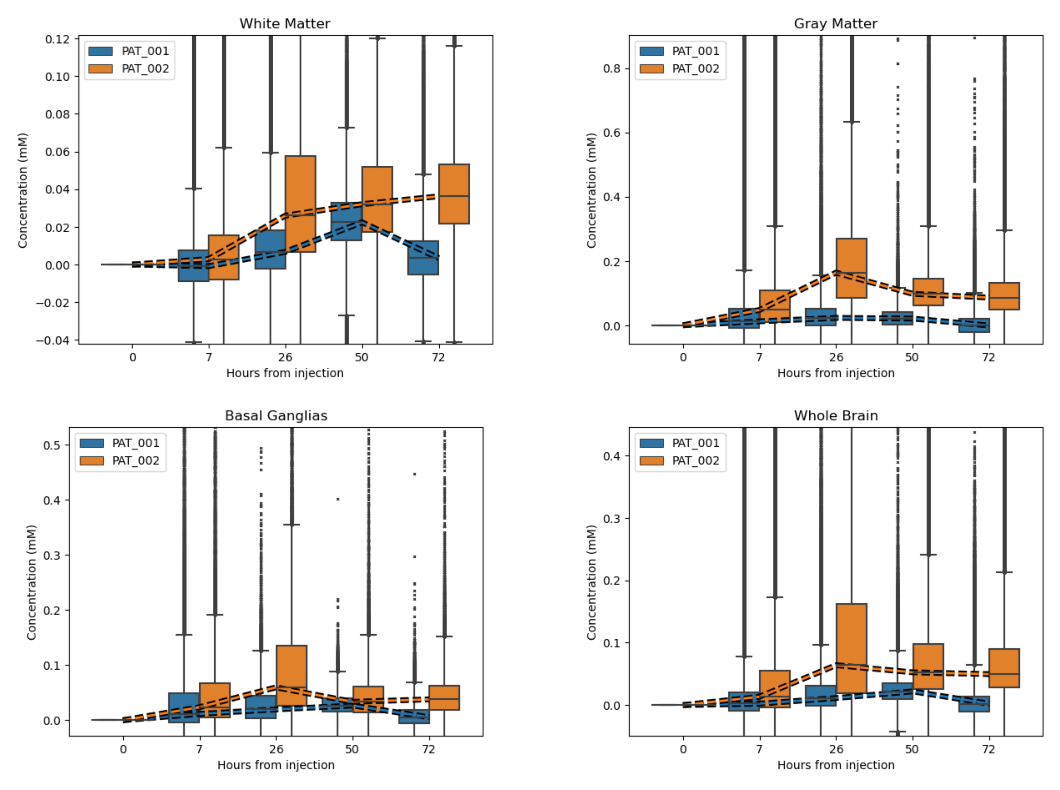

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for idx, group in enumerate(groups):
    im = PIL.Image.open(figpath / f"boxplot_{group}_w_curves.png")
    ax_idx = np.unravel_index(idx, (2, 2))
    axs[ax_idx].imshow(im)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
plt.tight_layout()
plt.show()